<a href="https://colab.research.google.com/github/Mvideoo/Vzlet_robot/blob/main/Vzlet_robot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 12.1 MB/s eta 0:00:00


In [ ]:
!unzip руды.zip

Archive:  руды.zip
   creating: руды/
   creating: руды/train/
   creating: руды/train/алюминий/
  inflating: руды/train/алюминий/0.016157544776741695.jpg  
  inflating: руды/train/алюминий/0.01690569550789489.jpg  
  inflating: руды/train/алюминий/0.03807908086579581.jpg  
  inflating: руды/train/алюминий/0.04176122691687911.jpg  
  inflating: руды/train/алюминий/0.06507594189159793.jpg  
  inflating: руды/train/алюминий/0.09390450671039308.jpg  
  inflating: руды/train/алюминий/0.10851258665507602.jpg  
  inflating: руды/train/алюминий/0.11292876767294413.jpg  
  inflating: руды/train/алюминий/0.12176135042600689.jpg  
  inflating: руды/train/алюминий/0.1360342052414677.jpg  
  inflating: руды/train/алюминий/0.1374039742223655.jpg  
  inflating: руды/train/алюминий/0.14460985812658889.jpg  
  inflating: руды/train/алюминий/0.1618824565322945.jpg  
  inflating: руды/train/алюминий/0.16599194583586308.jpg  
  inflating: руды/train/алюминий/0.2478424440249528.jpg  
  inflating: руды/tra

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
import torch.nn.functional as F

cudnn.benchmark = True
plt.ion()   # interactive mode

In [ ]:

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/руды'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### Visualize a few images
Let's visualize a few training images so as to understand the data
augmentations.



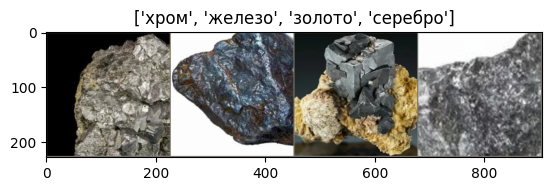

In [27]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Training the model

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

### Visualizing the model predictions

Generic function to display predictions for a few images




In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]} ground truth {class_names[labels[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Finetuning the ConvNet

Load a pretrained model and reset final fully connected layer.




In [ ]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
model_ft.fc.register_forward_hook(lambda m, inp, out: F.dropout(out, p=0.5, training=m.training))


num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 8)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 137MB/s]


### Train and evaluate

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=28)

Epoch 0/27
----------
train Loss: 1.8753 Acc: 0.3528
val Loss: 1.5017 Acc: 0.4837

Epoch 1/27
----------
train Loss: 1.7142 Acc: 0.3883
val Loss: 1.4417 Acc: 0.5425

Epoch 2/27
----------
train Loss: 1.6649 Acc: 0.4304
val Loss: 1.5708 Acc: 0.5098

Epoch 3/27
----------
train Loss: 1.6578 Acc: 0.4417
val Loss: 1.7111 Acc: 0.4379

Epoch 4/27
----------
train Loss: 1.6126 Acc: 0.4531
val Loss: 1.7972 Acc: 0.4510

Epoch 5/27
----------
train Loss: 1.4508 Acc: 0.5178
val Loss: 1.5035 Acc: 0.5229

Epoch 6/27
----------
train Loss: 1.4524 Acc: 0.5210
val Loss: 1.6845 Acc: 0.5359

Epoch 7/27
----------
train Loss: 1.1121 Acc: 0.6343
val Loss: 1.2908 Acc: 0.6275

Epoch 8/27
----------
train Loss: 1.1193 Acc: 0.6100
val Loss: 1.3455 Acc: 0.5621

Epoch 9/27
----------
train Loss: 1.0987 Acc: 0.6068
val Loss: 1.2544 Acc: 0.6209

Epoch 10/27
----------
train Loss: 1.0280 Acc: 0.6424
val Loss: 1.2320 Acc: 0.6340

Epoch 11/27
----------
train Loss: 0.9919 Acc: 0.6715
val Loss: 1.2897 Acc: 0.6209

Ep

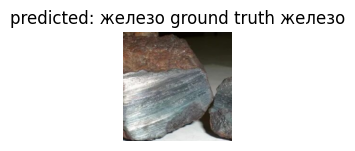

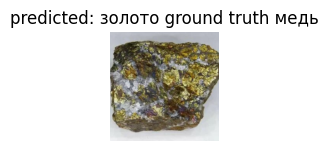

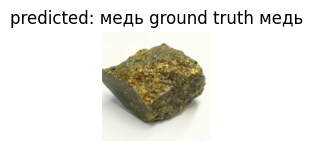

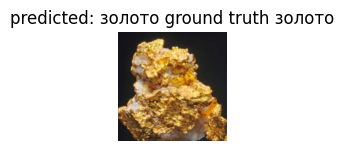

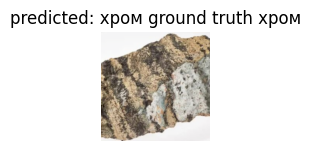

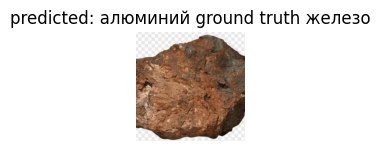

In [ ]:
visualize_model(model_ft)

## ConvNet as fixed feature extractor

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad = False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.



In [ ]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
model_ft.fc.register_forward_hook(lambda m, inp, out: F.dropout(out, p=0.5, training=m.training))
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 8)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

### Train and evaluate

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=14)

Epoch 0/13
----------
train Loss: 1.9956 Acc: 0.2880
val Loss: 1.6294 Acc: 0.4248

Epoch 1/13
----------
train Loss: 1.8318 Acc: 0.3366
val Loss: 1.5521 Acc: 0.4444

Epoch 2/13
----------
train Loss: 1.7259 Acc: 0.3964
val Loss: 1.5136 Acc: 0.4641

Epoch 3/13
----------
train Loss: 1.6257 Acc: 0.4385
val Loss: 1.5509 Acc: 0.4575

Epoch 4/13
----------
train Loss: 1.5509 Acc: 0.4515
val Loss: 1.5336 Acc: 0.5359

Epoch 5/13
----------
train Loss: 1.5501 Acc: 0.4612
val Loss: 1.4130 Acc: 0.4641

Epoch 6/13
----------
train Loss: 1.5248 Acc: 0.4903
val Loss: 1.6374 Acc: 0.4706

Epoch 7/13
----------
train Loss: 1.3467 Acc: 0.5340
val Loss: 1.4014 Acc: 0.5556

Epoch 8/13
----------
train Loss: 1.3494 Acc: 0.5227
val Loss: 1.3811 Acc: 0.5359

Epoch 9/13
----------
train Loss: 1.3341 Acc: 0.5615
val Loss: 1.3783 Acc: 0.5163

Epoch 10/13
----------
train Loss: 1.3273 Acc: 0.5275
val Loss: 1.4048 Acc: 0.5490

Epoch 11/13
----------
train Loss: 1.2275 Acc: 0.5566
val Loss: 1.4598 Acc: 0.5621

Ep

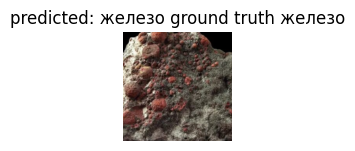

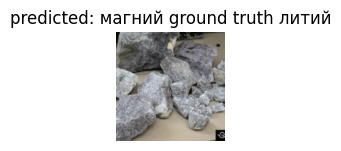

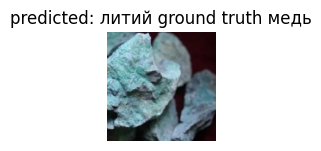

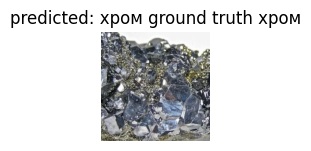

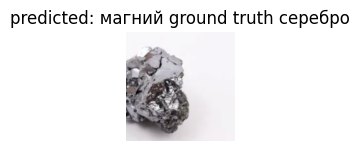

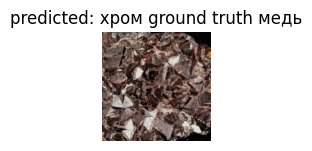

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()

## Inference on custom images

Use the trained model to make predictions on custom images and visualize
the predicted class labels along with the images.




In [ ]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

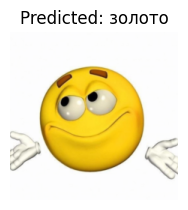

In [ ]:
visualize_model_predictions(
    model_conv,
    img_path='/content/потрясающе.jpg'
)

plt.ioff()
plt.show()